In [1]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggsignif))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(biomaRt))
options(bitmapType = 'cairo', device = 'png')

setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
outFold <- sprintf('%sCAD_SHIP_replication', fold_notebook)

tissues <- c("Liver", "Whole_Blood")
type_data <- 'tscore'
type_input <- 'zscaled'
type_cluster <- 'Cases'
pheno_name <- 'CAD'
gene_exp_fold <- "/psycl/g/mpsziller/lucia/CAD_SHIP/GENE_EXPR/"

color_tissues <- read.table(sprintf('%scolor_tissues.txt', fold_notebook), h=T, stringsAsFactors = F)

gene_ann <- read.delim(sprintf("%sHumanHT-12_V3_0_R3_11283641_A_probes.txt", gene_exp_fold), header = T, stringsAsFactors = F)
gene_exp <- read.table(gzfile(sprintf("%sSHIP-TREND_GX_plate01-14_QuantileNormalized.log2Transformd-zz_transposed-resid-SHIP_2022_27.txt.gz", gene_exp_fold)), 
                    h=T, stringsAsFactors = F)

path_act_fold <- gene_exp_fold
Reactome_ann <- read.delim(sprintf("%sfiltered_WB_Liver_Pathway_Reactome_scores_phenotypeFormat_info.txt", path_act_fold), 
                            header=T, sep="\t", stringsAsFactors = F)
GO_ann <- read.delim(sprintf("%sfiltered_WB_Liver_Pathway_GO_scores_phenotypeFormat_info.txt", path_act_fold), 
                          header=T, sep="\t", stringsAsFactors = F)
GO_ann <- GO_ann %>% 
    dplyr::rename(path_GO_id = path, path = path_name) %>%
    dplyr::select(-path_ont, -path_GO_id)

In [2]:
# association with actual gene expression
t <- tissues[1]
fold_SHIP <- "/psycl/g/mpsziller/lucia/CAD_SHIP/Results/PriLer/"

cl_pred <- get(load(sprintf("%s/%s/tscore_corrPCs_zscaled_predictClusterCases_PGmethod_HKmetric.RData",fold_SHIP, t))) 
fold_UKBB <- sprintf("OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/", t)
test_gene <- read.table(sprintf("%s/%s/test_GX_%s_corrPCs_%s_cluster%s_phenoAssociationGLM_prediction_modelUKBB.txt", 
                                fold_SHIP, t, type_data, type_input, type_cluster), h=T, stringsAsFactors = F, sep = ' ')

test_pathR <- read.table(sprintf("%s/%s/Reactome_%s_corrPCs_%s_cluster%s_phenoAssociationGLM_prediction_modelUKBB.txt", 
                                fold_SHIP, t, type_data, type_input, type_cluster), h=T, stringsAsFactors = F, sep = ' ')
test_pathGO <- read.table(sprintf("%s/%s/GO_%s_corrPCs_%s_cluster%s_phenoAssociationGLM_prediction_modelUKBB.txt", 
                                fold_SHIP, t, type_data, type_input, type_cluster), h=T, stringsAsFactors = F, sep = ' ')

feat_gene <- get(load(sprintf("%s/%s/tscoreOriginal_corrPCs_tscoreClusterCases_featAssociation.RData", fold_SHIP, t)))
feat_gene <- feat_gene$test_feat[[2]] # get prediction in whole blood
feat_gene <-  feat_gene %>% dplyr::rename(Symbol_gene = feat)

feat_path <- get(load(sprintf("%s/%s/pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData", fold_SHIP, t)))
feat_path <- feat_path$test_feat[[2]] # get prediction in whole blood

feat_gene_UKBB <- get(load(sprintf("%stscoreOriginal_corrPCs_tscoreClusterCases_featAssociation.RData", fold_UKBB)))
feat_gene_UKBB <- do.call(rbind, feat_gene_UKBB$test_feat)
feat_gene_UKBB <-  feat_gene_UKBB %>% dplyr::rename(Symbol_gene = feat)

feat_path_UKBB <- get(load(sprintf("%spathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData", fold_UKBB)))
feat_path_UKBB <- do.call(rbind, feat_path_UKBB$test_feat)

test_path <- rbind(test_pathR, test_pathGO)
ann_path <- rbind(Reactome_ann, GO_ann)


In [3]:
n_char <- unique(nchar(test_gene$pheno_id))

gene_ann$new_id <- sapply(gene_ann$Array_Address_Id, 
       function(x) paste0("X", paste0(rep("0", n_char - nchar(x) -1), collapse = ""), x))

test_gene$Symbol_gene <- gene_ann$Symbol[match(test_gene$pheno_id, gene_ann$new_id)]
test_gene$Entrez_Gene_ID <- gene_ann$Entrez_Gene_ID[match(test_gene$pheno_id, gene_ann$new_id)]                          
test_gene$Definition <- gene_ann$Definition[match(test_gene$pheno_id, gene_ann$new_id)]
test_gene$Cytoband <- gene_ann$Cytoband[match(test_gene$pheno_id, gene_ann$new_id)]
                                                  

In [4]:
# convert to entrez_gene_id
genes_list <- unique(feat_gene$Symbol_gene)
hsmart <- useMart(dataset = "hsapiens_gene_ensembl", biomart = "ensembl")
mapping_genes <- getBM(
  attributes = c('ensembl_gene_id', 'entrezgene_id', 'hgnc_symbol'), 
  filters = 'hgnc_symbol',
  values = genes_list,
  mart = hsmart
)

mapping_genes <- mapping_genes[!duplicated(mapping_genes$entrezgene_id),]
# for duplicates consider only those in gene_ann
id_genes <- mapping_genes$hgnc_symbol[duplicated(mapping_genes$hgnc_symbol)]
rm_entrez <- c()
for(i in 1:length(id_genes)){
     tmp <- gene_ann[gene_ann$Symbol %in% id_genes[i],]
     id_rm <- setdiff(as.character(mapping_genes$entrezgene_id[mapping_genes$hgnc_symbol %in% id_genes[i]]), 
                      as.character(tmp$Entrez_Gene_ID))
     rm_entrez <- c(rm_entrez, id_rm)
}

feat_gene$Entrez_Gene_ID <- mapping_genes$entrezgene_id[match(feat_gene$Symbol_gene,mapping_genes$hgnc_symbol)]
feat_gene_UKBB$Entrez_Gene_ID <- mapping_genes$entrezgene_id[match(feat_gene_UKBB$Symbol_gene,mapping_genes$hgnc_symbol)]
feat_gene_UKBB <- feat_gene_UKBB[feat_gene_UKBB$tissue %in% "Whole_Blood", ]

common_feat <- unique(intersect(test_gene$Entrez_Gene_ID, feat_gene$Entrez_Gene_ID))
table(is.na(gene_ann$Entrez_Gene_ID))

length(unique(test_gene$Entrez_Gene_ID))
length(unique(feat_gene$Entrez_Gene_ID))
length(unique(feat_gene_UKBB$Entrez_Gene_ID))
length(common_feat)




FALSE  TRUE 
36156 12647 

[1] 24925

[1] 2548

[1] 2548

[1] 2411

In [5]:
comp_id <- unique(test_gene$comp)
tot <- list()
tot_nom_SHIP <- list()
for(i in 1:length(comp_id)){
    
    # get genes significant in UKBB
    tmp_UKBB <- feat_gene_UKBB %>% 
                    dplyr::filter(Entrez_Gene_ID %in% common_feat, comp == comp_id[i], pval_corr <= 0.01)
    print(nrow(tmp_UKBB))
    
    tmp_feat <- feat_gene %>% 
        dplyr::filter(Entrez_Gene_ID %in% common_feat, 
                      comp == comp_id[i], 
                      Symbol_gene %in% tmp_UKBB$Symbol_gene) %>%
        dplyr::filter(!is.na(Entrez_Gene_ID))
    
    tmp_pheno <- test_gene %>% 
        dplyr::filter(Entrez_Gene_ID %in% common_feat, 
                      comp == comp_id[i]) %>%
        dplyr::filter(!is.na(Entrez_Gene_ID))
    
    tot[[i]] <- inner_join(tmp_pheno, tmp_feat, by = "Entrez_Gene_ID")
    tot[[i]]$pval_corr.x <- p.adjust(p = tot[[i]]$pvalue, method = "BH")
    
    tmp_feat <- feat_gene %>% 
        dplyr::filter(Entrez_Gene_ID %in% common_feat, 
                      comp == comp_id[i], 
                      pval <= 0.05) %>%
        dplyr::filter(!is.na(Entrez_Gene_ID))
        print(nrow(tmp_feat))

    tot_nom_SHIP[[i]] <- inner_join(tmp_pheno, tmp_feat, by = "Entrez_Gene_ID")

}

tot <- do.call(rbind, tot)
tot_nom_SHIP <- do.call(rbind, tot_nom_SHIP)

tot$type <- "ns"
tot$type[tot$pval_corr.y <= 0.05 & tot$pval_corr.x <= 0.05] <- "both"
tot$type[tot$pval_corr.y <= 0.05 & tot$pval_corr.x > 0.05] <- "only imputed"
tot$type[tot$pval_corr.x <= 0.05 & tot$pval_corr.y > 0.05] <- "only measured"
tot$type <- factor(tot$type, levels = c("ns","both", "only imputed", "only measured"))
tot <- tot[order(tot$type),]
tot$label_gene <- ""
tot$label_gene[tot$pvalue <= 0.0001] <- tot$Symbol_gene.x[tot$pvalue <= 0.0001]
tot$label_gene[tot$Symbol_gene.x %in% c("TMEM116", "PSRC1")] <- tot$Symbol_gene.x[tot$Symbol_gene.x %in% c("TMEM116", "PSRC1")]
#tot$label_gene[tot$pval <= 0.000000001] <- tot$Symbol_gene.y[tot$pval <= 0.000000001]
tot$label_gene[tot$type == "both"] <- tot$Symbol_gene.x[tot$type == "both"]



[1] 10
[1] 160
[1] 79
[1] 169
[1] 13
[1] 138
[1] 77
[1] 168


In [6]:
feat_gene_UKBB[feat_gene_UKBB$Symbol_gene == "GSTM2",]
feat_gene[feat_gene$Symbol_gene == "GSTM2",]

,Symbol_gene,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,Entrez_Gene_ID
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
162944,GSTM2,gr1_vs_all,7.49e-06,0.070942933,0.03966334,0.10270129,0.003194069,0.0008061944,Whole_Blood,2946
166782,GSTM2,gr2_vs_all,9.09e-04,-0.054274245,-0.08713781,-0.02206801,0.042033036,0.0811335349,Whole_Blood,2946
170620,GSTM2,gr3_vs_all,8.45e-01,0.003877278,-0.03512105,0.04287599,0.993904382,0.9895847793,Whole_Blood,2946
174458,GSTM2,gr4_vs_all,7.74e-04,-0.056350422,-0.08991295,-0.02334968,0.034948376,0.0707288571,Whole_Blood,2946
178296,GSTM2,gr5_vs_all,3.59e-04,0.140426564,0.06233723,0.21959131,0.153093556,0.0341050000,Whole_Blood,2946


,Symbol_gene,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,Entrez_Gene_ID
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
149,GSTM2,gr1_vs_all,2.98e-09,0.18909287,0.12627528,0.251650740,7.622840e-07,6.726035e-07,Whole_Blood,2946
3987,GSTM2,gr2_vs_all,7.00e-02,-0.06845570,-0.14344607,0.005571409,7.942177e-01,8.167295e-01,Whole_Blood,2946
7825,GSTM2,gr3_vs_all,2.76e-01,-0.05526363,-0.15748135,0.043887868,9.671342e-01,9.428095e-01,Whole_Blood,2946
11663,GSTM2,gr4_vs_all,1.25e-07,-0.20585048,-0.28237231,-0.129715821,1.065833e-05,2.447066e-05,Whole_Blood,2946
15501,GSTM2,gr5_vs_all,6.27e-02,0.31909833,-0.01822566,0.668363224,9.872718e-01,7.955685e-01,Whole_Blood,2946


,comp,sp_corr
,<chr>,<dbl>
gr1,gr1,0.1092258
gr2,gr2,0.2598451
gr3,gr3,0.7897855
gr4,gr4,0.2791953


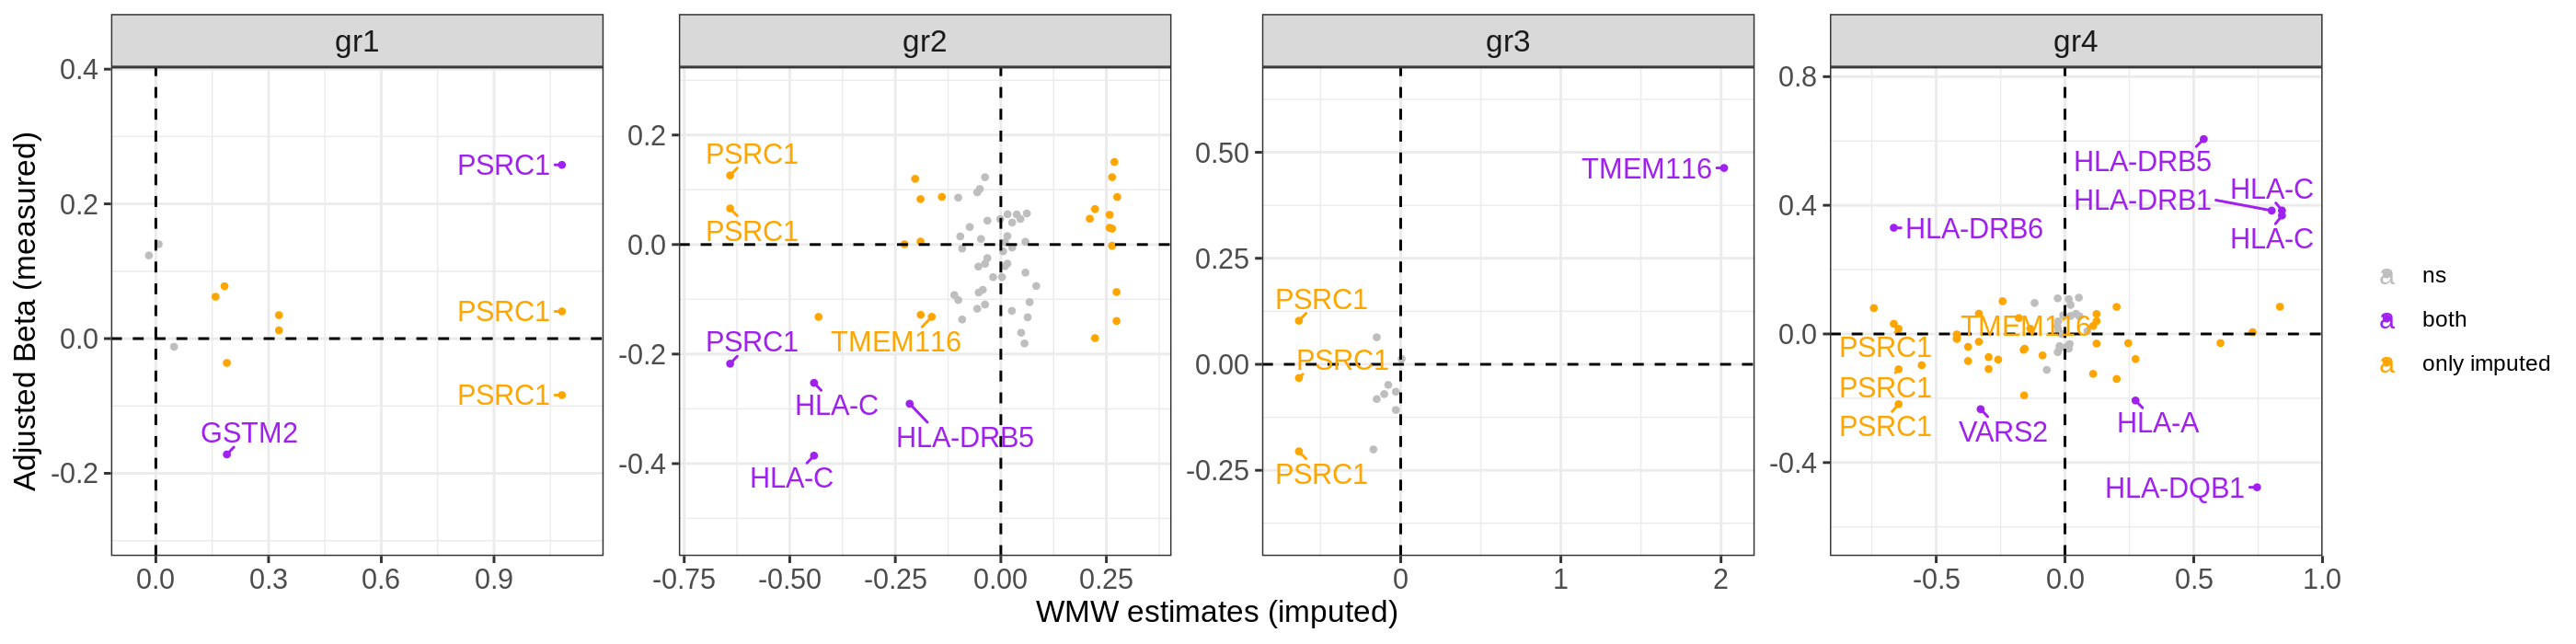

In [17]:
options(repr.plot.width = 14, repr.plot.height = 3.5, repr.plot.res = 200)

tot$comp <- sapply(tot$comp.x, function(x) strsplit(x, split = "_vs_all")[[1]])
P <- length(unique(tot$comp))
gr_color <- pal_d3(palette = 'category20')(P)
sp_corr <- sapply(sort(unique(tot$comp)), function(x) cor(method = "pearson", tot$beta[tot$comp == x], tot$estimates[tot$comp == x]) )                   

dat_text <- data.frame(comp = sort(unique(tot$comp)), sp_corr = sp_corr)
dat_text
#geom_text(
#  data    = dat_text,
#  mapping = aes(x = -Inf, y = -Inf, label = label),
#  hjust   = -0.1,
#  vjust   = -1)


pl <- ggplot(tot, aes(x = estimates, y = beta, color = type, 
                       ymin = CI_low.x, ymax = CI_up.x, 
                       xmin = CI_low.y, xmax = CI_up.y, label = label_gene))+
  geom_point(size = 0.8)+
  #geom_errorbar(width = 0.05, size = 0.3)+
  #geom_errorbarh(height = 0.05, size = 0.3)+
  xlab('WMW estimates (imputed)')+ylab('Adjusted Beta (measured)')+
  geom_vline(xintercept = 0, linetype = 'dashed', color = 'black')+
  geom_hline(yintercept = 0, linetype = 'dashed', color = 'black')+
  facet_wrap(.~comp, nrow = 1, scales = "free") +
  scale_color_manual(values = c("grey", "purple", "orange", "red")) +
  geom_text_repel(max.overlaps = Inf, min.segment.length = 0)+
  theme_bw()+theme(legend.position = 'right', legend.title = element_blank(),
                   strip.text = element_text(size = 12),
                   axis.text = element_text(size = 11), axis.title = element_text(size = 12))
pl
pl <- ggplot_gtable(ggplot_build(pl))
    stripr <- which(grepl('strip-t', pl$layout$name))
    fills <- gr_color
    k <- 1
    for (i in stripr) {
      j <- which(grepl('rect', pl$grobs[[i]]$grobs[[1]]$childrenOrder))
      pl$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
      k <- k+1
    }

ggsave(plot = pl, filename = sprintf('%s/%s_test_GX_compare_genes_WMW_WBtissue.pdf', outFold, t), device = 'pdf', 
       width = 13, height = 3.5)
                



	Pearson's product-moment correlation

data:  tot_nom_SHIP$estimates and tot_nom_SHIP$beta
t = 6.5534, df = 1005, p-value = 8.968e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1424459 0.2609552
sample estimates:
      cor 
0.2024416 



       -1         1 
0.4528302 0.5471698 


	Exact binomial test

data:  n_success and n_tot
number of successes = 551, number of trials = 1007, p-value = 0.003036
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.5158291 0.5782340
sample estimates:
probability of success 
             0.5471698 


[1] 0.03972195

`geom_smooth()` using formula 'y ~ x'



`geom_smooth()` using formula 'y ~ x'



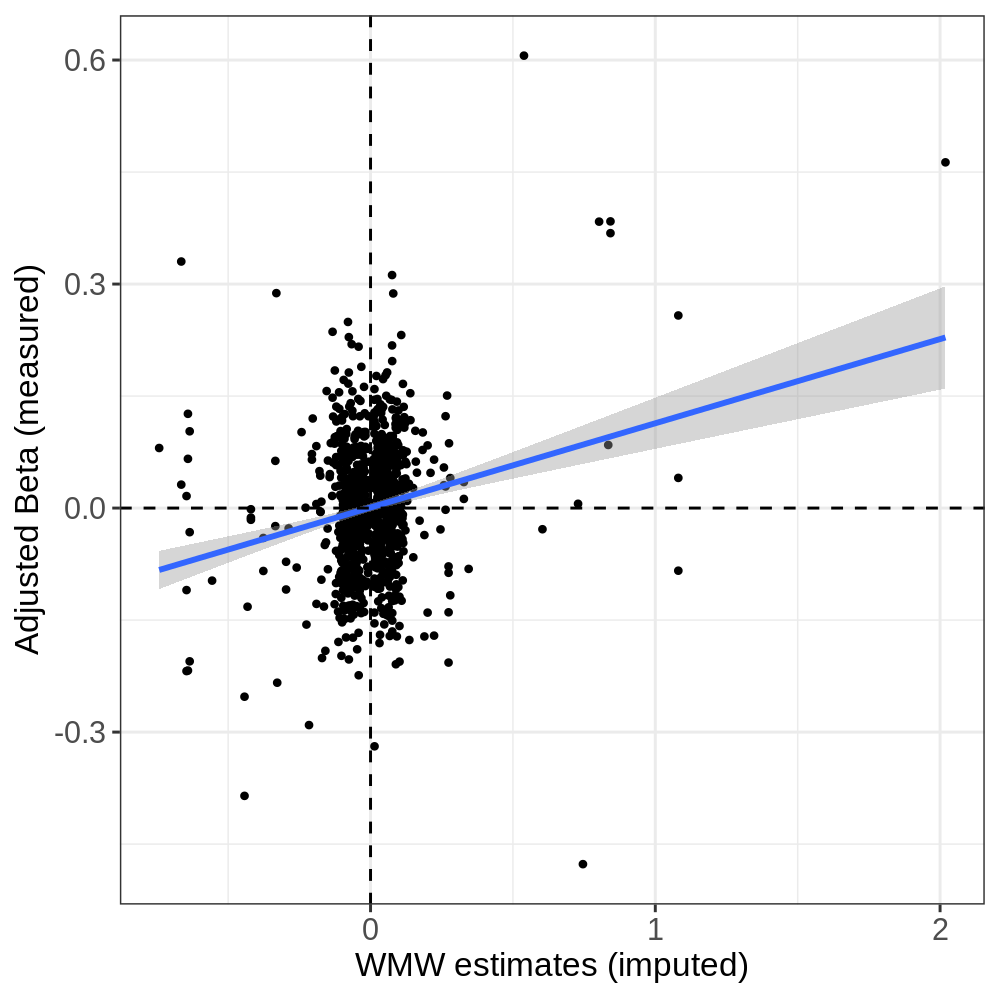

In [8]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

cor.test(tot_nom_SHIP$estimates, 
         tot_nom_SHIP$beta)

table(sign(tot_nom_SHIP$estimates * tot_nom_SHIP$beta))/nrow(tot_nom_SHIP)
n_success = sum(sign(tot_nom_SHIP$estimates * tot_nom_SHIP$beta) == 1)
n_tot = nrow(tot_nom_SHIP)
binom.test(x = n_success, n = n_tot)

sum(sign(tot_nom_SHIP$estimates * tot_nom_SHIP$beta) == 1 & tot_nom_SHIP$pvalue <= 0.05)/n_tot

pl <- ggplot(tot_nom_SHIP, aes(x = estimates, y = beta)) +
                       #ymin = CI_low.x, ymax = CI_up.x, 
                       #xmin = CI_low.y, xmax = CI_up.y))+
  geom_point(size = 0.8)+
  geom_smooth(method = "lm") +
  #geom_errorbar(width = 0.05, size = 0.3)+
  #geom_errorbarh(height = 0.05, size = 0.3)+
  xlab('WMW estimates (imputed)')+ylab('Adjusted Beta (measured)')+
  geom_vline(xintercept = 0, linetype = 'dashed', color = 'black')+
  geom_hline(yintercept = 0, linetype = 'dashed', color = 'black')+
  theme_bw()+
  theme(legend.position = 'right', legend.title = element_blank(),
                   strip.text = element_text(size = 12),
                   axis.text = element_text(size = 11), axis.title = element_text(size = 12))
pl
ggsave(plot = pl, filename = sprintf('%s/%s_test_GX_compare_genes_WMW_WBtissue_overall.pdf', outFold, t), device = 'pdf', 
       width = 5, height = 5)






	Pearson's product-moment correlation

data:  tot_nom_SHIP$estimates[id_FDR] and tot_nom_SHIP$beta[id_FDR]
t = 3.8406, df = 108, p-value = 0.0002074
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1704665 0.5013448
sample estimates:
      cor 
0.3466436 



       -1         1 
0.4272727 0.5727273 


	Exact binomial test

data:  n_success and n_tot
number of successes = 63, number of trials = 110, p-value = 0.1523
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.4748465 0.6665926
sample estimates:
probability of success 
             0.5727273 


[1] 0.1454545

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



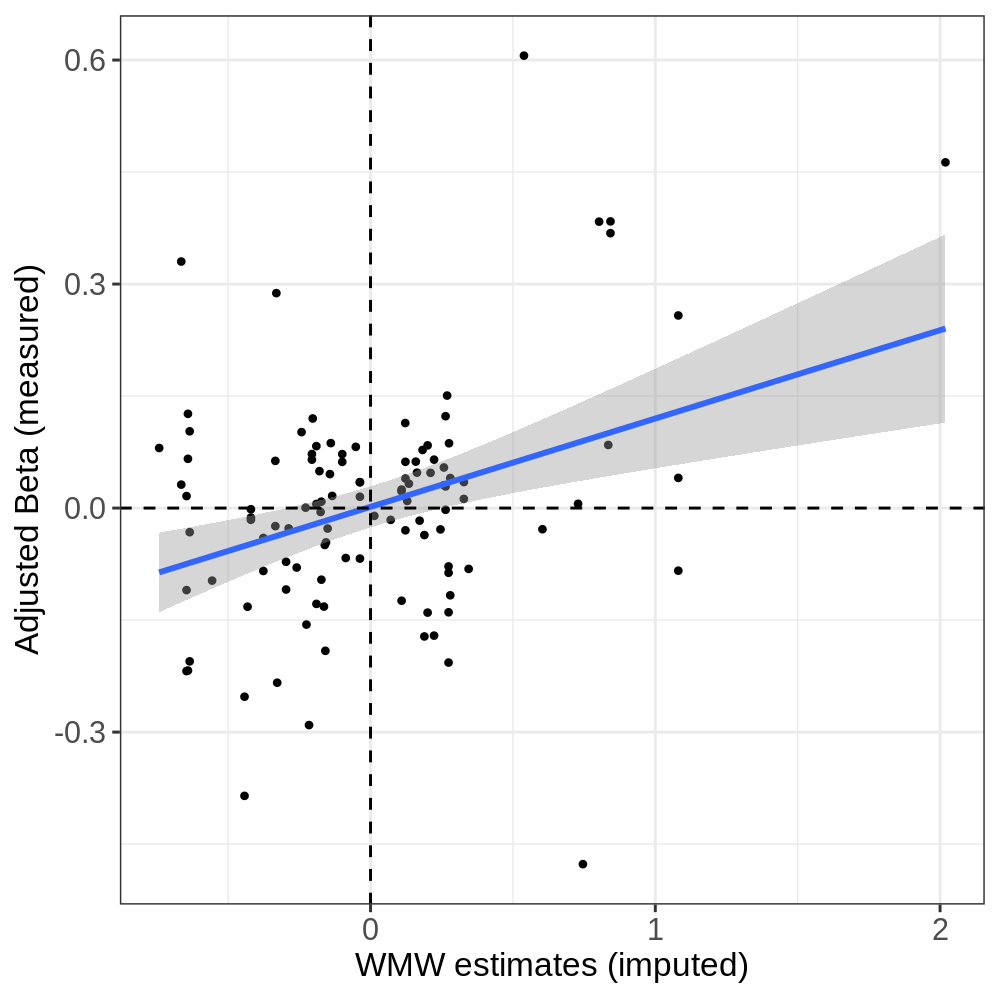

In [9]:
# FDR significant results

id_FDR <- tot_nom_SHIP$pval_corr.y <= 0.05
cor.test(tot_nom_SHIP$estimates[id_FDR], 
         tot_nom_SHIP$beta[id_FDR])

table(sign(tot_nom_SHIP$estimates[id_FDR] * tot_nom_SHIP$beta[id_FDR]))/nrow(tot_nom_SHIP[id_FDR,])

n_success = sum(sign(tot_nom_SHIP$estimates[id_FDR] * tot_nom_SHIP$beta[id_FDR]) == 1)
n_tot = sum(id_FDR)
binom.test(x = n_success, n = n_tot)

sum(sign(tot_nom_SHIP$estimates[id_FDR] * tot_nom_SHIP$beta[id_FDR]) == 1 & tot_nom_SHIP$pvalue[id_FDR] <= 0.05)/n_tot


pl <- ggplot(subset(tot_nom_SHIP, pval_corr.y <= 0.05), aes(x = estimates, y = beta))+
                       # ymin = CI_low.x, ymax = CI_up.x, 
                       # xmin = CI_low.y, xmax = CI_up.y))+
  geom_point(size = 0.8)+
  geom_smooth(method = "lm") +
  #geom_errorbar(width = 0.05, size = 0.3)+
  #geom_errorbarh(height = 0.05, size = 0.3)+
  xlab('WMW estimates (imputed)')+ylab('Adjusted Beta (measured)')+
  geom_vline(xintercept = 0, linetype = 'dashed', color = 'black')+
  geom_hline(yintercept = 0, linetype = 'dashed', color = 'black')+
  theme_bw()+
  theme(legend.position = 'right', legend.title = element_blank(),
                   strip.text = element_text(size = 12),
                   axis.text = element_text(size = 11), axis.title = element_text(size = 12))
pl
ggsave(plot = pl, filename = sprintf('%s/%s_test_GX_compare_genes_WMW_WBtissue_FDR005_overall.pdf', outFold, t), device = 'pdf', 
       width = 4, height = 4)



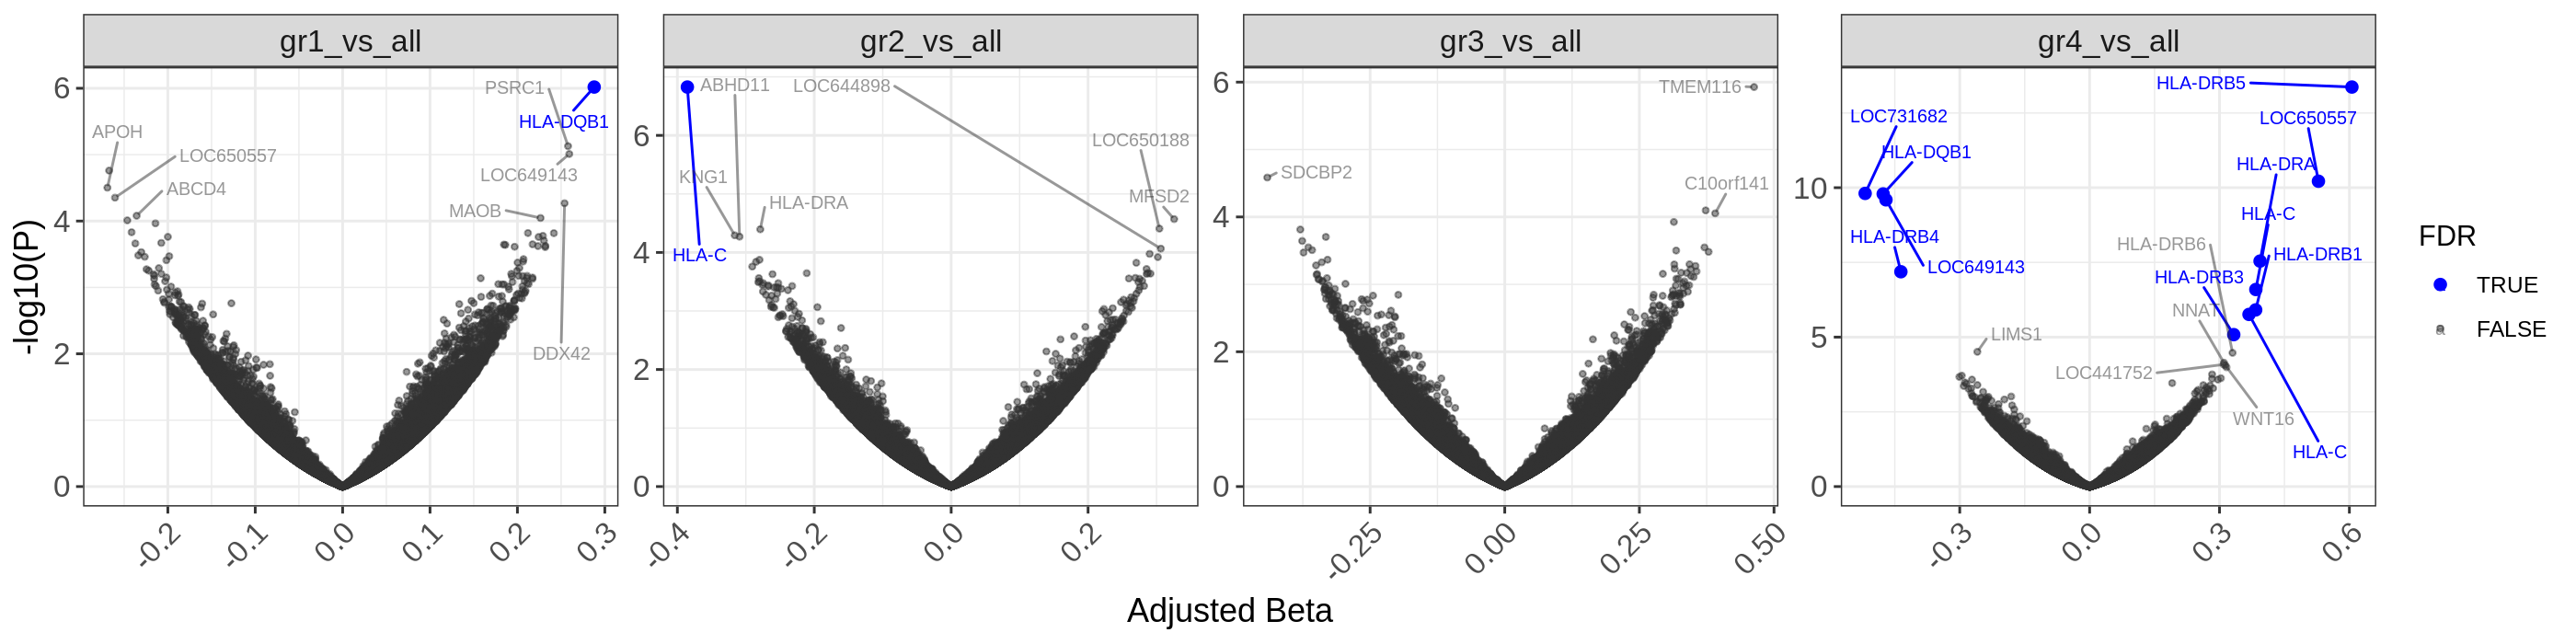

In [18]:
# volcano plot
options(repr.plot.width = 14, repr.plot.height = 3.5, repr.plot.res = 200)

test_gene$log10p <- -log10(test_gene$pvalue)
test_gene$FDR <- FALSE
test_gene$FDR[test_gene$pval_corr <= 0.05] <- TRUE
test_gene$FDR <- factor(test_gene$FDR, levels = c("TRUE","FALSE"))
test_gene$label_gene <- "" 
test_gene$label_gene[test_gene$pvalue <= 0.0001] <- test_gene$Symbol_gene[test_gene$pvalue <= 0.0001]

pl <- ggplot(test_gene, aes(x = beta, y = log10p, 
                            color = FDR, alpha = FDR, size = FDR, label = label_gene))+
        geom_point() + 
        facet_wrap(comp~., nrow = 1, scales = "free")+
        theme_bw() + 
        geom_text_repel(max.overlaps = Inf, min.segment.length = 0, size = 2.5, force = 100)+
        scale_alpha_manual(values = c(1, 0.5))+
        scale_size_manual(values = c(1.8, 0.8))+
        xlab("Adjusted Beta") + ylab("-log10(P)")+
        scale_color_manual(values = c("blue", "grey20"))+
        theme(legend.position = "right", strip.text = element_text(size = 12),
              plot.title = element_text(hjust = 0.5, size = 13), 
              axis.text = element_text(size = 12),
              axis.text.x = element_text(angle = 45, hjust = 1),
              axis.title = element_text(size = 13))

pl

pl <- ggplot_gtable(ggplot_build(pl))
stripr <- which(grepl('strip-t', pl$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
    j <- which(grepl('rect', pl$grobs[[i]]$grobs[[1]]$childrenOrder))
    pl$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
    k <- k+1
}


ggsave(plot = pl, filename = sprintf('%s/%s_test_GX_vulcanoPlot_genes_WBtissue.png', outFold, t), device = 'png', 
       width = 13, height = 3.5)

In [12]:
feat_gene_UKBB[feat_gene_UKBB$Symbol_gene %in% c("SDCBP2",  "APOH", "ABCD4",
                                        "MAOB",  "KNG1", "MFSD2",
                                        "LIMS1", "HLA-DRA", "HLA-DRB3"),]

feat_gene[feat_gene$Symbol_gene %in% c("SDCBP2", "APOH", "ABCD4",
                                       "MAOB",  "KNG1","MFSD2",
                                        "LIMS1", "HLA-DRA", "HLA-DRB3"),]

,Symbol_gene,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,Entrez_Gene_ID
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
166327,SDCBP2,gr1_vs_all,0.5370,-0.005241041,-0.022249454,0.011436014,0.9595000,0.9701564,Whole_Blood,27111
170165,SDCBP2,gr2_vs_all,0.3290,-0.008995622,-0.027546418,0.009060958,0.8861067,0.9588190,Whole_Blood,27111
174003,SDCBP2,gr3_vs_all,0.0203,0.026626053,0.004031126,0.051444015,0.6412268,0.6334260,Whole_Blood,27111
177841,SDCBP2,gr4_vs_all,0.5570,-0.005500730,-0.024217107,0.012970909,0.9838363,0.9701564,Whole_Blood,27111
181679,SDCBP2,gr5_vs_all,0.4930,0.013315594,-0.025460546,0.054538161,0.9717950,0.9671151,Whole_Blood,27111


,Symbol_gene,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,Entrez_Gene_ID
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
3532,SDCBP2,gr1_vs_all,0.9300,-0.001600214,-0.038301394,0.03543067,0.9865360,0.9959086,Whole_Blood,27111
7370,SDCBP2,gr2_vs_all,0.8460,-0.004426499,-0.050546916,0.04115047,0.9789313,0.9902978,Whole_Blood,27111
11208,SDCBP2,gr3_vs_all,0.0811,0.057465638,-0.006761232,0.13640085,0.9269032,0.8312480,Whole_Blood,27111
15046,SDCBP2,gr4_vs_all,0.2990,-0.024496909,-0.076236907,0.02127453,0.8968839,0.9461096,Whole_Blood,27111
18884,SDCBP2,gr5_vs_all,0.9020,0.010109865,-0.163527347,0.23626513,0.9938423,0.9948758,Whole_Blood,27111


In [13]:
# plot gene expression across groups

plot_gene_dist <- function(gene_exp, cl, gene_id, test_gene, thr_pval, file_save = NULL){
    
    id_samples <- intersect(rownames(gene_exp), cl_pred$cl_new$id)
    cl_subset <- cl_pred$cl_new[match(id_samples,cl_pred$cl_new$id),]

    gr_id <- sort(unique(cl_subset$gr))
    gene_exp_subset <- gene_exp[as.character(cl_subset$id),]

    gr_color <- pal_d3(palette = 'category20')(length(unique(cl_subset$gr)))
    P <- length(gr_id)

    red <- test_gene %>% dplyr::filter(Symbol_gene %in% gene_id, pvalue <= thr_pval)
    n_genes <- length(unique(red$pheno_id))
    plot_violin <- list()
    for(i in 1:n_genes){
        df <- data.frame(gene_exp_subset[, unique(red$pheno_id)[i], drop=F], 
                 gr = paste0("gr", cl_subset$gr))
        colnames(df)[1] <- "value"
    
        tmp <- test_gene[test_gene$pheno_id == unique(red$pheno_id)[i],]
        tmp <- tmp[match(paste0('gr',gr_id, '_vs_all'), tmp$comp),]
        tmp$star_ann <- format(tmp$pvalue, scientific = T,  digits = 2)
        tmp$star_ann[tmp$pvalue >= 0.05 ] <- '-'

        plot_violin[[i]] <- ggplot(df, aes(x = gr, y = value, fill = gr))+
          geom_violin(alpha = 0.8)+
          stat_summary(fun = median, geom = "pointrange", color = "grey20") +
          #geom_boxplot(width=0.2, fill="white", outlier.shape = NA)+
          geom_point(size = 0.1, alpha = 0.3, position = position_jitterdodge())+
          xlab('')+ ylab(gene_id)+
          ggtitle(unique(red$pheno_id)[i]) + 
          scale_fill_manual(values = gr_color, drop = F)+
          theme_bw()+
          theme(legend.position = 'none', 
            plot.title=element_text(hjust = 0.5, size = 13), 
            axis.text = element_text(size=13),
            axis.title = element_text(size=13))+
          annotate("text", x = paste0("gr", 1:P), 
                   y = rep(max(df$value, na.rm = T) + max(df$value,  na.rm = T)*0.03, P), 
                   label = tmp$star_ann, size = 4)

    }

    pl_tot <- ggarrange(plotlist = plot_violin, nrow = 1, ncol = n_genes)
    
    if(!is.null(file_save)){
        
        ggsave(plot = pl_tot, 
           filename = sprintf('%sgene%s.pdf', file_save, gene_id),
           device = 'pdf', 
           width = 4*length(plot_violin), height = 3.5)
    }
    
    return(pl_tot)
}

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


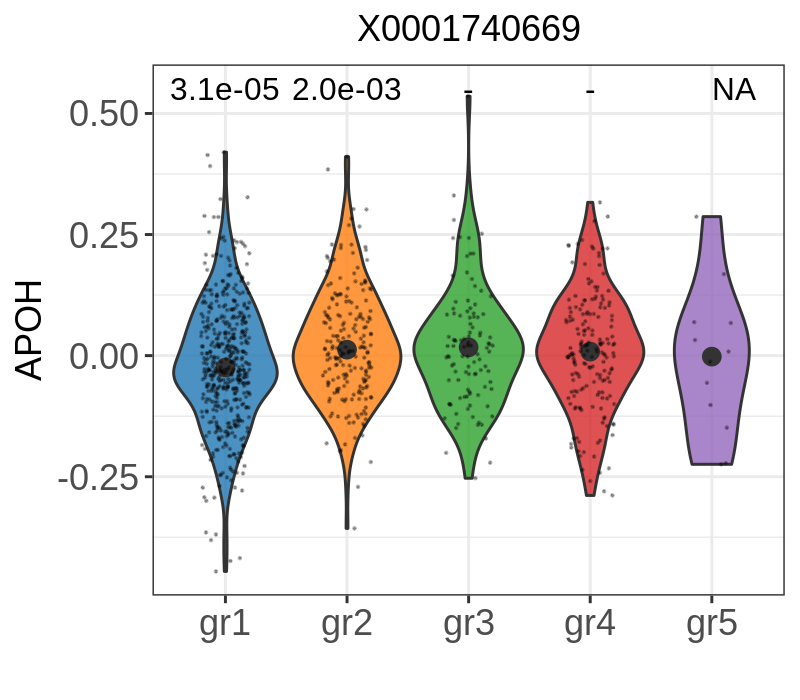

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


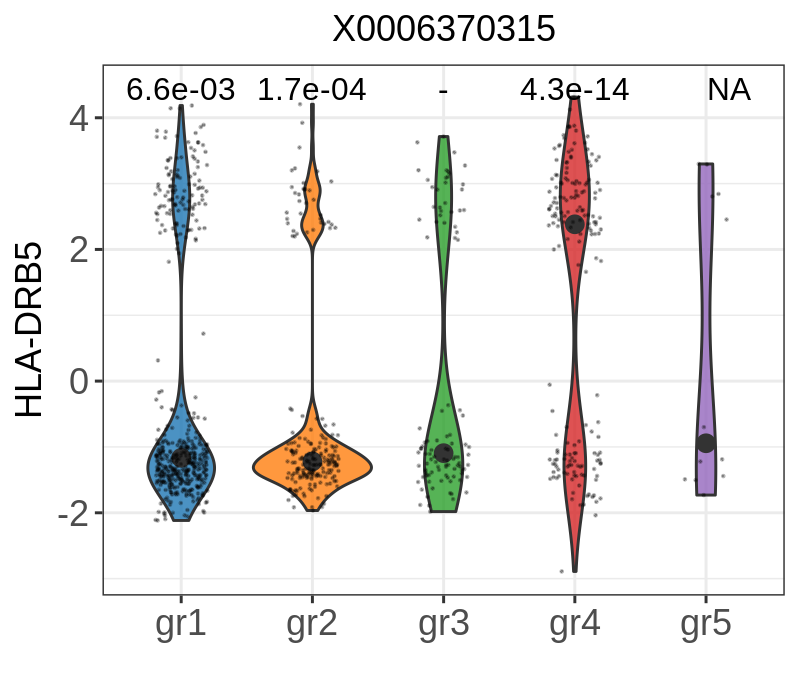

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


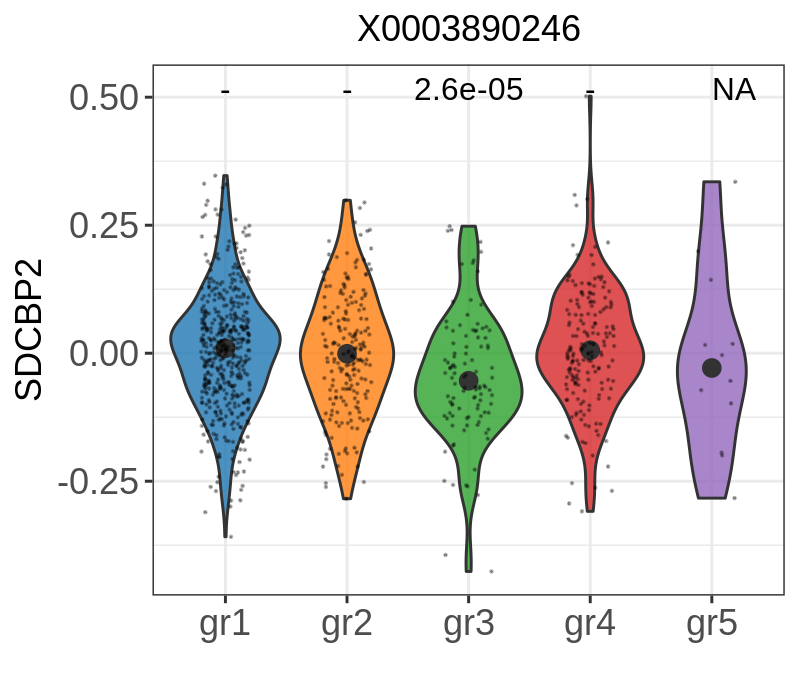

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


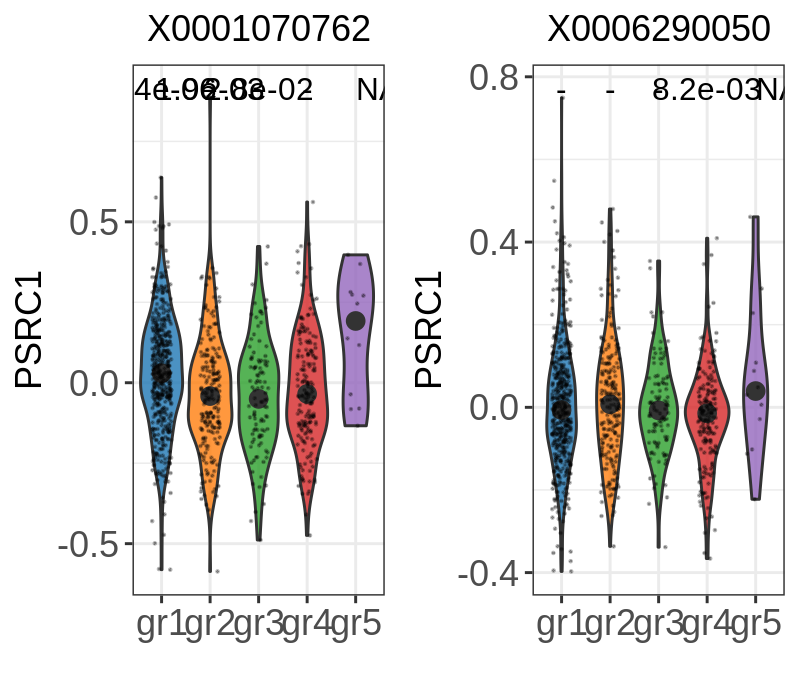

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


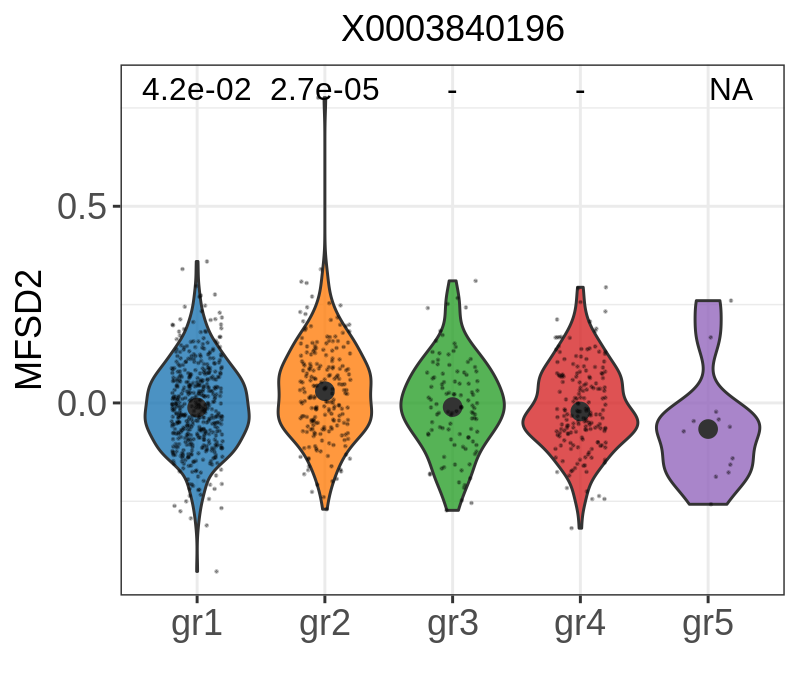

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


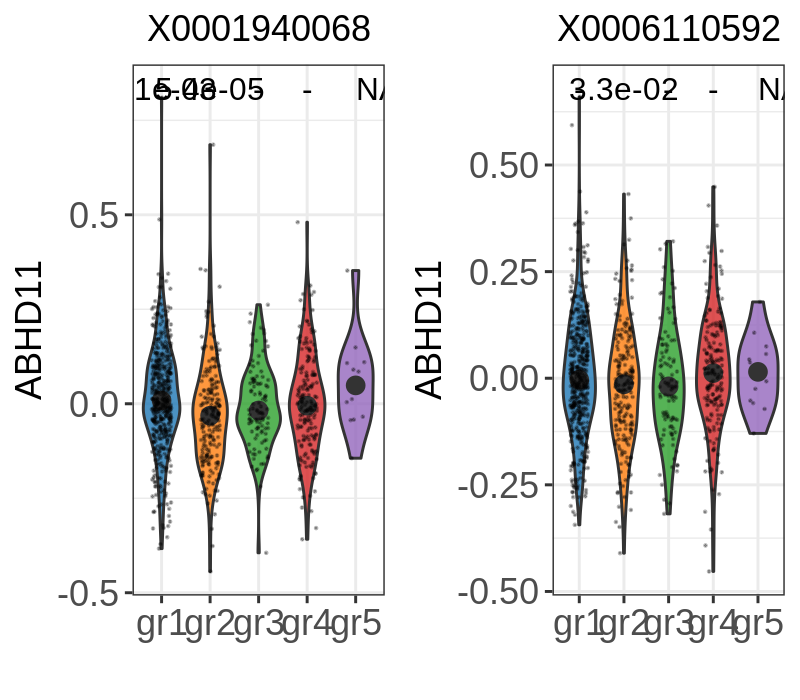

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


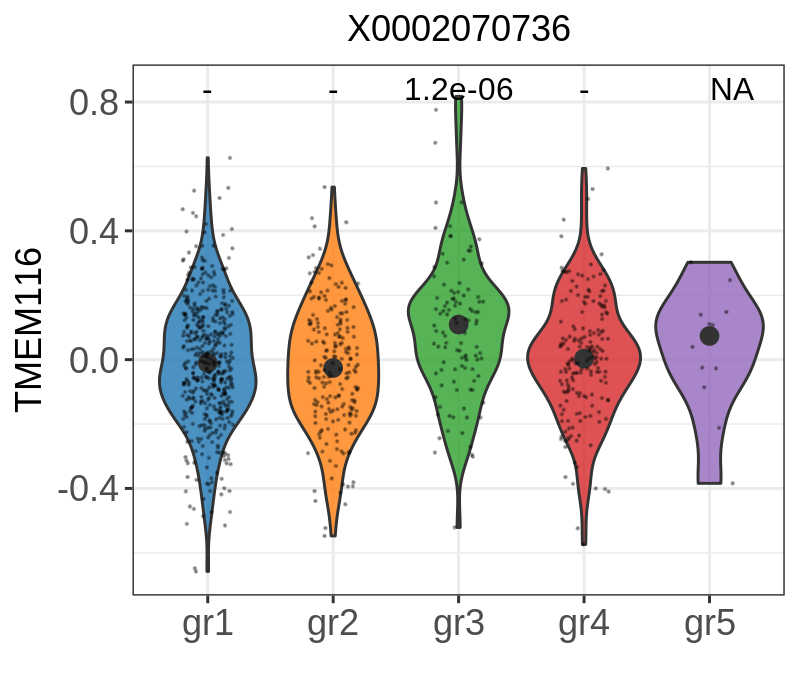

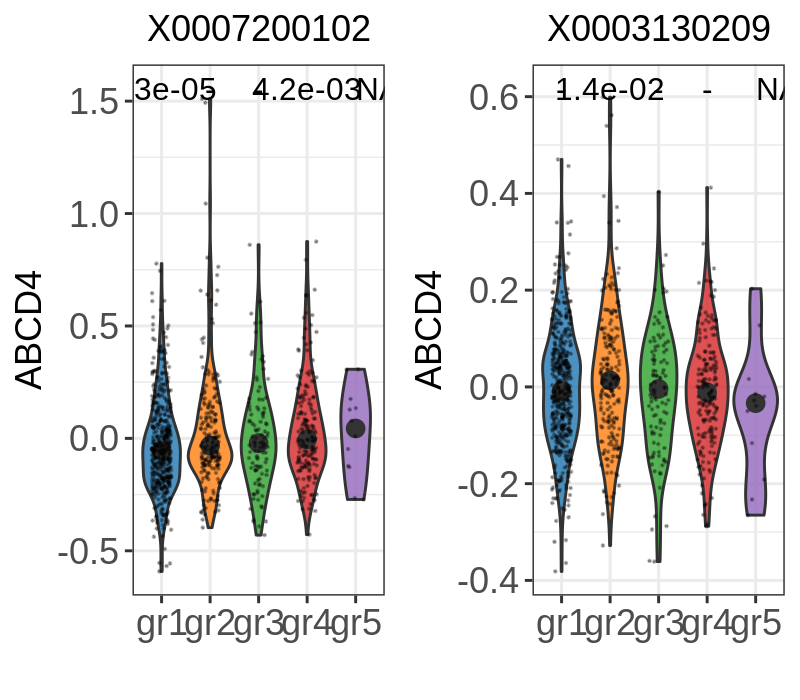

In [15]:
options(repr.plot.width = 4, repr.plot.height = 3.5, repr.plot.res = 200)

plot_gene_dist(gene_exp = gene_exp, cl = cl_pred, 
               gene_id = "APOH", 
               test_gene = test_gene, 
               thr_pval = 0.05, 
               file_save = sprintf('%s/%s_test_GX_violinPlot_', fold_SHIP,t))

plot_gene_dist(gene_exp = gene_exp, cl = cl_pred, 
               gene_id = "HLA-DRB5", 
               test_gene = test_gene, 
               thr_pval = 0.05, 
               file_save = sprintf('%s/%s_test_GX_violinPlot_', fold_SHIP,t))

plot_gene_dist(gene_exp = gene_exp, cl = cl_pred, 
               gene_id = "SDCBP2", 
               test_gene = test_gene, 
               thr_pval = 0.05, 
               file_save = sprintf('%s/%s_test_GX_violinPlot_',fold_SHIP, t))

plot_gene_dist(gene_exp = gene_exp, cl = cl_pred, 
               gene_id = "PSRC1", 
               test_gene = test_gene, 
               thr_pval = 0.05, 
               file_save = sprintf('%s/%s_test_GX_violinPlot_',fold_SHIP, t))
               
plot_gene_dist(gene_exp = gene_exp, cl = cl_pred, 
               gene_id = "MFSD2", 
               test_gene = test_gene, 
               thr_pval = 0.05, 
               file_save = sprintf('%s/%s_test_GX_violinPlot_',fold_SHIP, t))

plot_gene_dist(gene_exp = gene_exp, cl = cl_pred, 
               gene_id = "ABHD11", 
               test_gene = test_gene, 
               thr_pval = 0.05, 
               file_save = sprintf('%s/%s_test_GX_violinPlot_',fold_SHIP, t))
               

plot_gene_dist(gene_exp = gene_exp, cl = cl_pred, 
               gene_id = "TMEM116", 
               test_gene = test_gene, 
               thr_pval = 0.05, 
               file_save = sprintf('%s/%s_test_GX_violinPlot_',fold_SHIP, t))

plot_gene_dist(gene_exp = gene_exp, cl = cl_pred, 
               gene_id = "ABCD4", 
               test_gene = test_gene, 
               thr_pval = 0.05, 
               file_save = sprintf('%s/%s_test_GX_violinPlot_', fold_SHIP, t))

[1] 20

[1] "imt_auto_t0" "ldlch"       "crp_hs_re_z" "hyp_t0"      "igf1"       
[6] "sysbp_t0"    "diabp_t0"

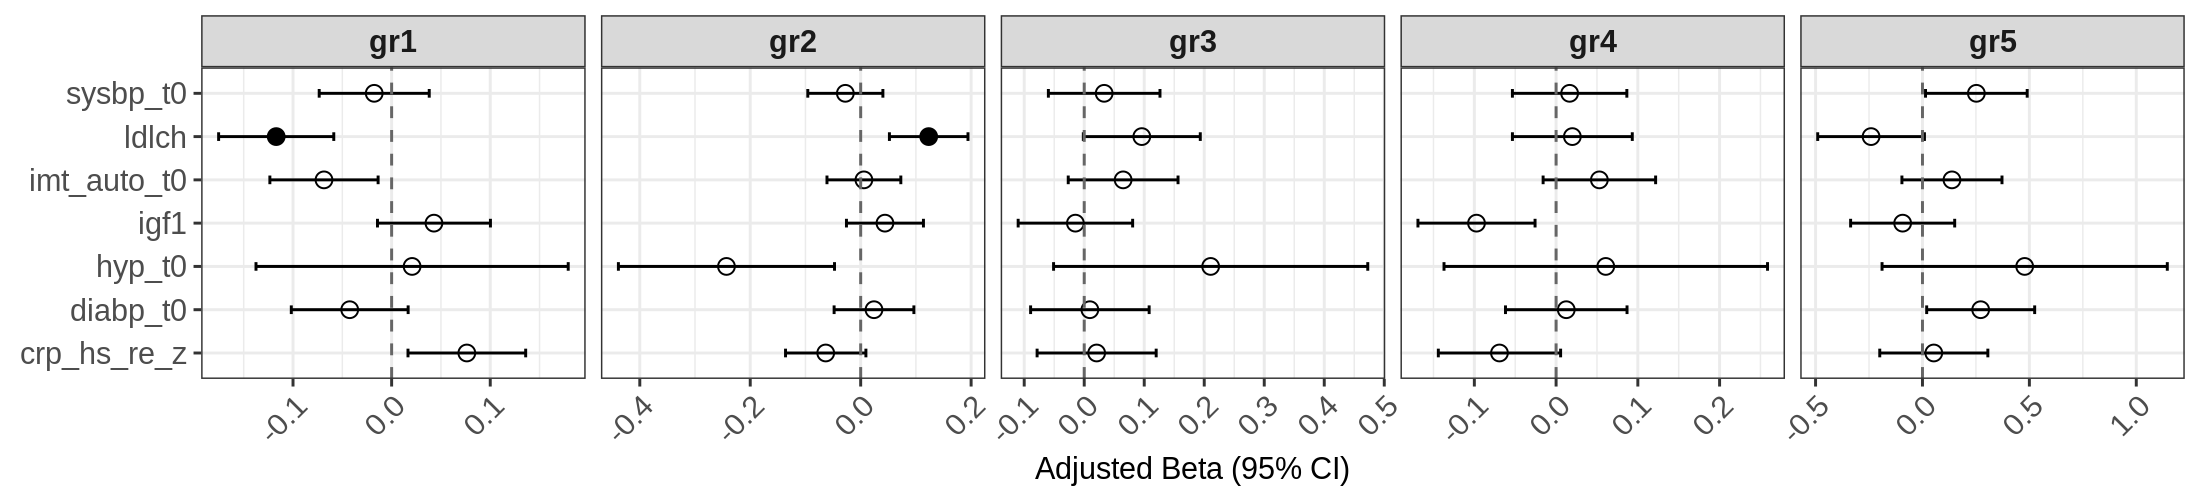

In [16]:
# get endophenotype
options(repr.plot.width = 11, repr.plot.height = 2.5, repr.plot.res = 200)

res_pheno <- read.table(sprintf("%s/%s/test_tscore_corrPCs_zscaled_clusterCases_phenoAssociationGLM_prediction_modelUKBB.txt", fold_SHIP, t))
length(unique(res_pheno$pheno_id))


pheno_keep <- unique(res_pheno$pheno_id[res_pheno$pvalue <= 0.05])
pheno_keep

df_red <- res_pheno %>% filter(pheno_id %in% pheno_keep) %>% 
    mutate(sign = ifelse(pval_corr <= 0.05, 'yes', 'no')) %>%
    mutate(new_id = pheno_id) %>%
    mutate(comp = sapply(comp, function(x) strsplit(x, split = "_vs_all")[[1]]))
  
df_red$new_id <- factor(df_red$new_id, levels = unique(df_red$new_id))
df_red$comp <- factor(df_red$comp, levels = unique(df_red$comp))
df_red$sign <- factor(df_red$sign, levels = c('no', 'yes'))
                         
P <- length(unique(df_red$comp))
gr_color <- pal_d3(palette = 'category20')(P)
                         
df_red$CI_low[df_red$type_pheno != "CONTINUOUS"] <- log(df_red$CI_low[df_red$type_pheno != "CONTINUOUS"])
df_red$CI_up[df_red$type_pheno != "CONTINUOUS"] <- log(df_red$CI_up[df_red$type_pheno != "CONTINUOUS"])

pl_beta <-  ggplot(df_red, aes(x = pheno_id, y = beta, shape = sign))+
      geom_point(size = 2.5)+
      geom_errorbar(aes(ymin=CI_low, ymax=CI_up), width=.2, position=position_dodge(0.05))+
      theme_bw()+ 
      ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
      facet_wrap(comp~., nrow = 1, strip.position="top", scales = "free_x")+
      theme(legend.position = 'none', plot.title = element_text(size=11), 
            axis.title.y = element_blank(), axis.title.x = element_text(size=11),
            axis.text.x = element_text(size = 11, angle = 45, hjust = 1), 
            axis.text.y = element_text(size = 11), 
            strip.text = element_text(size=11,   face = 'bold'))+
      scale_shape_manual(values=c(1, 19))+
      coord_flip()
pl_beta

pl_beta <- ggplot_gtable(ggplot_build(pl_beta))
stripr <- which(grepl('strip-t', pl_beta$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
    j <- which(grepl('rect', pl_beta$grobs[[i]]$grobs[[1]]$childrenOrder))
    pl_beta$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
    k <- k+1
}                         

ggsave(plot = pl_beta, filename = sprintf('%s/%s_test_phenotype_forestPlot.pdf', outFold, t), device = 'pdf', 
       width = 11, height = 2.5)
